# Portfolio 2: Analysing COVID-19 Data

This portfolio will look at the most relavent dataset of our lives COVID-19 confirmed cases for different regiens of the world. The dataset which I am going to use is an open dataset taken from Johs Hopkins University. This portfolio is the source of the graphs and visualisations that we see on the news. 

Here are some sample stories for reference:

* [From the ABC](https://www.abc.net.au/news/2020-03-26/coronavirus-covid19-global-spread-data-explained/12089028)
* [From the Guardian](https://www.theguardian.com/australia-news/datablog/ng-interactive/2020/apr/06/coronavirus-cases-in-australia-map-curve-confirmed-numbers-stats-how-many-covid-19-nsw-by-postcode-maps-victoria-live-data-qld-sa-wa-tas-nt-act-latest-statistics)
* [Coronavirus in Australia](https://www.covid19data.com.au/)
* [ArcGIS Dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) Johns Hopkins


## Getting the Data

The first step is to get a copy of the raw data.  The data is being made available by Johns Hopkins University in [this GitHub repository](https://github.com/CSSEGISandData/COVID-19). We're interestd in the global confirmed cases dataset.  

We are just reading data from the URL. The advantage of reading the URL is that we'll get live updates, but this might make it harder for us to repeat our experiments if the data changes.  Also, we would be making new requests for data every time we ran our worksheet putting load on the server.

In [6]:
#Importing needed libraries
import pandas as pd
import numpy as np
%matplotlib inline
# load the live dataset, assumes a working network connection
covid_data_url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
covid = pd.read_csv(covid_data_url)
covid

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,4687,4963,5226,5639,6053,6402,6664,7072,7653,8145
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,872,876,880,898,916,933,946,948,949,964
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,5891,6067,6253,6442,6629,6821,7019,7201,7377,7542
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,755,758,760,761,761,761,761,761,761,762
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,45,45,45,48,48,48,48,50,52,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,208,208,220,235,235,235,235,246,251,251
262,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,56,65,70,85,106,122,128,130,167,184
263,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,...,11,11,11,11,11,11,11,11,11,34
264,NaN,Tajikistan,38.861034,71.276093,0,0,0,0,0,0,...,661,729,801,907,1118,1322,1524,1729,1936,2140


## Explore the Data

The format of this data is one row per geographical region with columns for Lat/Long and then one column for each day's data.  Most regions are countries but in some cases, as in Australia, they are states.  

For the analysis we want to look at data for countries only, so the first operation on the data frame is to combine all of the rows for countries like Australia that are split into states.  We then want to drop the non-numeric columns to leave us with just the numbers on each day for each country.  This can be done using the [`groupby`](https://pandas.pydata.org/docs/getting_started/10min.html#grouping) method and the [`drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) method.  We can use these to make a new dataframe containing just the numerical data.

In [7]:
grouped = covid.groupby('Country/Region').sum()
grouped = grouped.drop(columns=['Lat', 'Long'])
grouped

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,4687,4963,5226,5639,6053,6402,6664,7072,7653,8145
Albania,0,0,0,0,0,0,0,0,0,0,...,872,876,880,898,916,933,946,948,949,964
Algeria,0,0,0,0,0,0,0,0,0,0,...,5891,6067,6253,6442,6629,6821,7019,7201,7377,7542
Andorra,0,0,0,0,0,0,0,0,0,0,...,755,758,760,761,761,761,761,761,761,762
Angola,0,0,0,0,0,0,0,0,0,0,...,45,45,45,48,48,48,48,50,52,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
West Bank and Gaza,0,0,0,0,0,0,0,0,0,0,...,375,375,375,375,375,376,381,388,391,398
Western Sahara,0,0,0,0,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6
Yemen,0,0,0,0,0,0,0,0,0,0,...,56,65,70,85,106,122,128,130,167,184


# Now, let's start our visualization of data.
Firstly, we will choose one country [using the `loc` method] to see the exponential rise in case number over time. So, We will look for the number of confirmed cases of COVID-19 of Australia.

In [8]:
grouped_australia=grouped.loc['Australia']
print(grouped_australia)

1/22/20       0
1/23/20       0
1/24/20       0
1/25/20       0
1/26/20       4
           ... 
5/16/20    7044
5/17/20    7054
5/18/20    7068
5/19/20    7072
5/20/20    7081
Name: Australia, Length: 120, dtype: int64


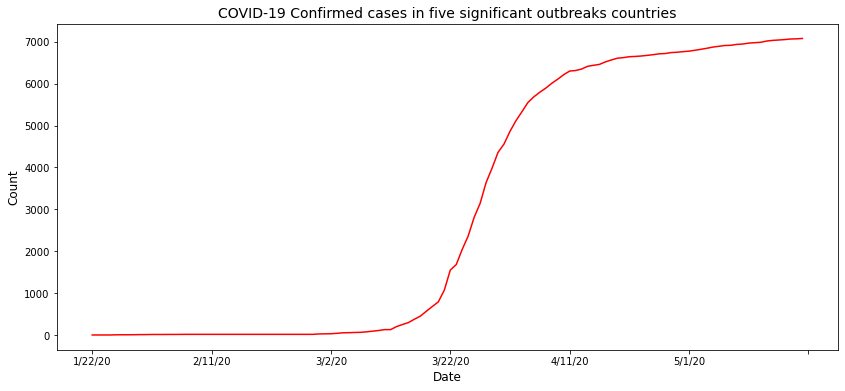

In [83]:
grouped_australia.plot(figsize=(14,6), color=['r'])
plot.title('COVID-19 Confirmed cases in five significant outbreaks countries', fontsize = 14)
plot.ylabel('Count', fontsize = 12)
plot.xlabel('Date', fontsize = 12)
plot.show()

## Comparing Countries

Here, Our goal is to see COVID-19 confirmed cases comparison between countries.  So, I am selecting five significant outbreaks countries such as Australia, China, Italy, US, and United Kingdom and plotting their data on the same graph to reproduce this visualisation. We will use loc method to select countries. Transpose() function is also used here to show countries as a columns.

In [84]:
significant_outbreaks=grouped.loc[['Australia', 'China', 'Italy', 'US', 'United Kingdom']].transpose()
significant_outbreaks

Country/Region,Australia,China,Italy,US,United Kingdom
1/22/20,0,548,0,1,0
1/23/20,0,643,0,1,0
1/24/20,0,920,0,2,0
1/25/20,0,1406,0,2,0
1/26/20,4,2075,0,5,0
...,...,...,...,...,...
5/16/20,7044,84044,224760,1467820,241461
5/17/20,7054,84054,225435,1486757,244995
5/18/20,7068,84063,225886,1508308,247709
5/19/20,7072,84063,226699,1528568,250138


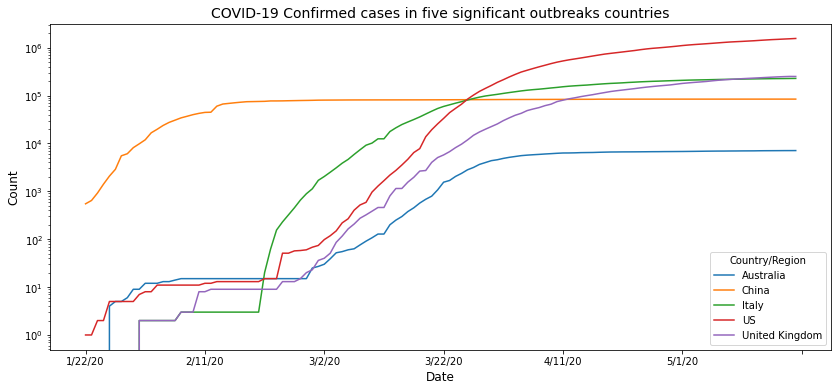

In [88]:
significant_outbreaks.plot(figsize=(14,6))
plot.title('COVID-19 Confirmed cases in five significant outbreaks countries', fontsize = 14)
plot.ylabel('Count', fontsize = 12)
plot.xlabel('Date', fontsize = 12)
plot.yscale('log')
plot.show()

**Challenge** 
A very useful visualisation shows the data for different countries aligned from the time that they have 100 confirmed cases.  To create this figure, I need to take only the part of each time series after the value is greater than or equal to 100 and then plotting this starting at 0 on the x-axis. We are using here iloc function to retrive the index label of a data frame from where the cases is greater than and equal to 100 for all five countries.

In [89]:
countries_greater100=significant_outbreaks[ significant_outbreaks.iloc[:,0:5]>= 100 ]
countries_greater100

Country/Region,Australia,China,Italy,US,United Kingdom
1/22/20,NaN,548,NaN,NaN,NaN
1/23/20,NaN,643,NaN,NaN,NaN
1/24/20,NaN,920,NaN,NaN,NaN
1/25/20,NaN,1406,NaN,NaN,NaN
1/26/20,NaN,2075,NaN,NaN,NaN
...,...,...,...,...,...
5/16/20,7044.0,84044,224760.0,1467820.0,241461.0
5/17/20,7054.0,84054,225435.0,1486757.0,244995.0
5/18/20,7068.0,84063,225886.0,1508308.0,247709.0
5/19/20,7072.0,84063,226699.0,1528568.0,250138.0


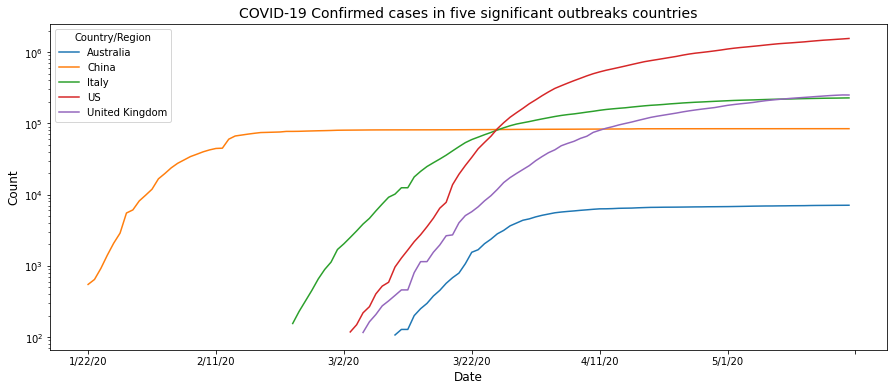

In [91]:
countries_greater100.plot(figsize=(15,6))
plot.title('COVID-19 Confirmed cases in five significant outbreaks countries', fontsize = 14)
plot.ylabel('Count', fontsize = 12)
plot.xlabel('Date', fontsize = 12)
plot.yscale('log')
plot.show()

## Normalisation by Population

The raw data includes the overall count of cases in each country. Clearly small countries will have smaller overall values than large countries.  It would be interesting to see whether the number of cases in China and the US was more per-capita than those in other countries and findinding which country has the highest number as a proportion of the population. (Here, we want to visualise the number of cases per million people in the population. For example, If a country has 25 cases and a population of 2.5 million they would have 10 cases per million).

So,to get this data we need population data. We will prefer to pick [United Nations Population Dynamics page](https://population.un.org/wpp/Download/Standard/CSV/) has data that predicts populations up to 2100 in CSV format.So that we can compute the number of confirmed cases for each country per million population.

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
#Reading csv format population data
population = pd.read_csv('files/WPP2019_TotalPopulationBySex (1).csv', index_col=0)
population.dropna(how="any", inplace=True)
population = population.fillna("", inplace=False)
population

,Location,VarID,Variant,Time,MidPeriod,PopMale,PopFemale,PopTotal,PopDensity
LocID,,,,,,,,,
4,Afghanistan,2,Medium,1950,1950.5,4099.243,3652.874,7752.117,11.874
4,Afghanistan,2,Medium,1951,1951.5,4134.756,3705.395,7840.151,12.009
4,Afghanistan,2,Medium,1952,1952.5,4174.450,3761.546,7935.996,12.156
4,Afghanistan,2,Medium,1953,1953.5,4218.336,3821.348,8039.684,12.315
4,Afghanistan,2,Medium,1954,1954.5,4266.484,3884.832,8151.316,12.486
...,...,...,...,...,...,...,...,...,...
716,Zimbabwe,207,Lower 95 PI,2080,2080.5,10576.533,11255.983,21836.893,56.448
716,Zimbabwe,207,Lower 95 PI,2085,2085.5,10293.349,11050.875,21355.988,55.205
716,Zimbabwe,207,Lower 95 PI,2090,2090.5,9920.336,10767.709,20689.956,53.483


Note, to use the population data I have to make sure that the country names match up in the different data sets.
I am using replace function to modify the data and trying to matching the countries name from both population and grouped data sets. We are doing this so that we can take Totalpopulation columsns from population data set and confirmed cases from grouped data set.

In [95]:
population['Location'].str.replace(r'United States of America', 'US')
population['Location'].str.replace(r'United Kingdom (and dependencies)', 'United Kingdom')
population['Location'].str.replace(r'Iran (Islamic Republic of)', 'Iran')

LocID
4      Afghanistan
4      Afghanistan
4      Afghanistan
4      Afghanistan
4      Afghanistan
          ...     
716       Zimbabwe
716       Zimbabwe
716       Zimbabwe
716       Zimbabwe
716       Zimbabwe
Name: Location, Length: 250876, dtype: object

Now, we will drop all the unwanted columns from columns_dropping data set because we are not going to use it any where.

In [97]:
columns_dropping = population.drop(columns=['VarID', 'Variant', 'Time', 'MidPeriod', 'PopDensity', 'PopMale', 'PopFemale'])
columns_dropping

,Location,PopTotal
LocID,,
4,Afghanistan,7752.117
4,Afghanistan,7840.151
4,Afghanistan,7935.996
4,Afghanistan,8039.684
4,Afghanistan,8151.316
...,...,...
716,Zimbabwe,21836.893
716,Zimbabwe,21355.988
716,Zimbabwe,20689.956


Here, we have to use groupby function on location s that we can fetch location and sum all the countries population as total.
This is because some counties populations data are not given in total.

In [100]:
total_population = columns_dropping.groupby('Location').sum()
pd.options.display.float_format = '{:,.4f}'.format
total_population

,PopTotal
Location,
Afghanistan,"63,768,456.2010"
Africa,"2,486,424,381.8460"
African Group,"275,355,065.1870"
African Union,"275,455,527.2150"
African Union: Central Africa,"36,332,725.0230"
...,...
World,"8,600,041,576.1330"
World Bank Regional Groups (developing only),"968,226,225.7180"
Yemen,"44,166,849.3000"


The next step we need to do is to use inner join so that we can take similar countries data from total_population data and confirmed cases from grouped data.

In [104]:
population_covid = total_population.join(grouped, how='inner')
population_covid

,PopTotal,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20
Afghanistan,"63,768,456.2010",0,0,0,0,0,0,0,0,0,...,4687,4963,5226,5639,6053,6402,6664,7072,7653,8145
Albania,"2,051,487.8390",0,0,0,0,0,0,0,0,0,...,872,876,880,898,916,933,946,948,949,964
Algeria,"54,028,509.8520",0,0,0,0,0,0,0,0,0,...,5891,6067,6253,6442,6629,6821,7019,7201,7377,7542
Angola,"84,885,829.6190",0,0,0,0,0,0,0,0,0,...,45,45,45,48,48,48,48,50,52,52
Antigua and Barbuda,"93,150.0160",0,0,0,0,0,0,0,0,0,...,25,25,25,25,25,25,25,25,25,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uzbekistan,"36,507,524.8820",0,0,0,0,0,0,0,0,0,...,2486,2519,2612,2645,2686,2738,2753,2791,2855,2939
Western Sahara,"842,677.1430",0,0,0,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6
Yemen,"44,166,849.3000",0,0,0,0,0,0,0,0,0,...,56,65,70,85,106,122,128,130,167,184
Zambia,"40,132,917.1740",0,0,0,0,0,0,0,0,0,...,267,441,446,654,654,679,753,761,772,832


Here, we are picking most recend day data and total population so that we can do per million cases calculation.

In [110]:
newdataframe = population_covid[['5/20/20','PopTotal']]
newdataframe

,5/20/20,PopTotal
Afghanistan,8145,"63,768,456.2010"
Albania,964,"2,051,487.8390"
Algeria,7542,"54,028,509.8520"
Angola,52,"84,885,829.6190"
Antigua and Barbuda,25,"93,150.0160"
...,...,...
Uzbekistan,2939,"36,507,524.8820"
Western Sahara,6,"842,677.1430"
Yemen,184,"44,166,849.3000"
Zambia,832,"40,132,917.1740"


Now we will calculate the per million cases. We will divide confirmed cases of countries by total population of cintries and then we will multiply by 1000000.

In [111]:
newdataframe['Result_permillion'] = newdataframe['5/20/20']/newdataframe['PopTotal']*1000000
newdataframe.sort_values(by='Result_permillion', ascending=False)

c:\users\61413\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,5/20/20,PopTotal,Result_permillion
Qatar,37097,"3,030,239.5720","12,242.2664"
Spain,232555,"35,585,923.8700","6,535.0278"
Luxembourg,3971,"662,959.6630","5,989.8064"
Singapore,29364,"5,079,756.6520","5,780.5919"
Iceland,1803,"316,926.9270","5,689.0086"
...,...,...,...
Malawi,71,"38,246,796.4930",1.8564
Burundi,42,"26,446,566.0010",1.5881
Papua New Guinea,8,"12,934,249.9590",0.6185
Angola,52,"84,885,829.6190",0.6126


## A Predictive Model

It is well understood that the spread of the virus follows an exponential pattern. This is because each infected person infects more than one new person on average, leading to exponential growth.  This is why the key to stopping the growth of the pandemic is to reduce the number of people infected by stopping contact and isolating infected poeple. 

An exponential curve has the equation $y = e^{mx}$. It can be converted to a linear relationship by taking the logarithm of each side: $log(y) = mx$.  This means that we can fit a linear regression model to the data as long as we take the log of the number of cases. 

Selecting a country with a clear exponential curve (for example, the US) and building a linear regression model to predict the log of the number of case. Also, testing how well the model fits the data. 

In [113]:
USA =grouped.loc['US']

Now, We will fit lInearRegression model to USA data

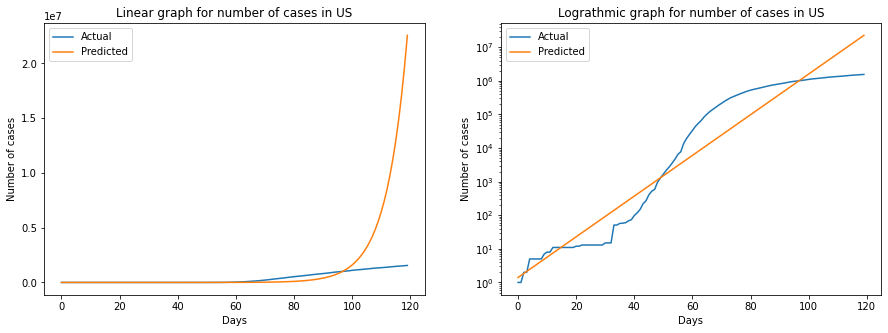

In [122]:
from sklearn.linear_model import LinearRegression
X = np.arange(len(USA)).reshape(-1,1)
y = USA.values
estimator = LinearRegression(normalize = True)
estimator.fit(X,np.log(y))
y_pred = np.exp(estimator.predict(X))

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(y)
plt.plot(y_pred)
plt.title("Linear graph for number of cases in US")
plt.ylabel("Number of cases")
plt.xlabel("Days")
plt.legend(["Actual","Predicted"])

plt.subplot(1,2,2)
plt.plot(y)
plt.plot(y_pred)
plt.title("Lograthmic graph for number of cases in US")
plt.ylabel("Number of cases")
plt.xlabel("Days")
plt.legend(["Actual","Predicted"])
plt.yscale('log')

The above graphS(Linear graph for number of cases in US and Lograthmic graph for number of cases in US.) showing the no of cases in as actual cases and predicted cases.

Now, selecting the data from China. This should show some divergence from the model since they have managed to slow the growth of cases. The questin arises here,  Can we show from the model that China's data does not show exponential growth?   If China had not acted to stop the virus, how many cases would there be now according to this simple model? 

Can we use this metric to identify countries where the virus is under control and those where it is not? 

In [123]:
China =grouped.loc['China']

Now, We will fit lInearRegression model to China data

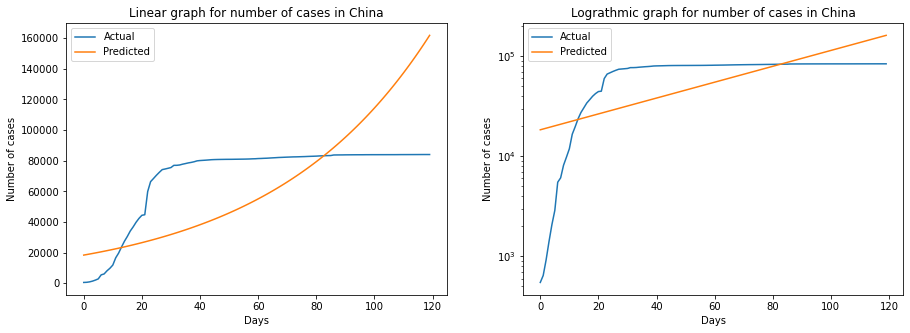

In [124]:
from sklearn.linear_model import LinearRegression
X = np.arange(len(USA)).reshape(-1,1)
y = China.values
estimator = LinearRegression(normalize = True)
estimator.fit(X,np.log(y))
y_pred = np.exp(estimator.predict(X))

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(y)
plt.plot(y_pred)
plt.title("Linear graph for number of cases in China")
plt.ylabel("Number of cases")
plt.xlabel("Days")
plt.legend(["Actual","Predicted"])

plt.subplot(1,2,2)
plt.plot(y)
plt.plot(y_pred)
plt.title("Lograthmic graph for number of cases in China")
plt.ylabel("Number of cases")
plt.xlabel("Days")
plt.legend(["Actual","Predicted"])
plt.yscale('log')

Now, we are going to check china's number of cases growth if china had not acted to slow the spread of cases.

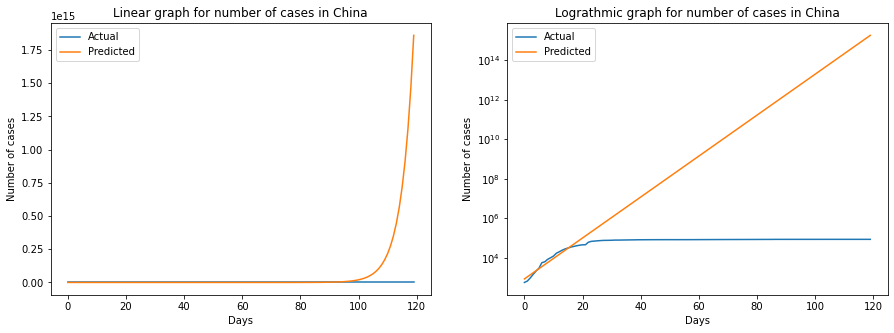

In [125]:
estimator.fit(X[:20],np.log(y[:20]))
y_pred = np.exp(estimator.predict(X))

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(y)
plt.plot(y_pred)
plt.title("Linear graph for number of cases in China")
plt.ylabel("Number of cases")
plt.xlabel("Days")
plt.legend(["Actual","Predicted"])

plt.subplot(1,2,2)
plt.plot(y)
plt.plot(y_pred)
plt.title("Lograthmic graph for number of cases in China")
plt.ylabel("Number of cases")
plt.xlabel("Days")
plt.legend(["Actual","Predicted"])
plt.yscale('log')